### Tryout model Pytorch

In [2]:
#!pip install pytorch-ignite
#!pip install -e /workspace/VisionWorks

#!nvidia-smi               #shell ?
#!nvcc --version           #shell ?
#!pip install tqdm
#!pip install sklearn

In [13]:
import wandb
from ignite.contrib.handlers.wandb_logger import *
from ignite.contrib.engines.common import * # does contain the setup_wandb_logging
import os

import ignite
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping

from PIL import Image
from read_lapchol import LapcholDataset
from matplotlib.pyplot import imshow
from transforms import ReadPILImage
import torch
from torch.optim import Adam
from torchvision.models import resnet18
from torchvision.models import resnet50
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np

import random

import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import sklearn
from sklearn.model_selection import KFold

from visionworks.transformation.loading.image_loading import LoadPILImage
from visionworks.transformation.image.image_transforms import ResizePILImage, ResizeNumpyImage, CenterCropTorchvision, ResizeTorchvision 
from visionworks.transformation import TorchvisionTformWrapper

from torchvision import transforms
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor

from transforms import LabelToInt, LabelToTensor, DicttoImageandLabel 



In [3]:
wandb.login()

wandb: Currently logged in as: jnjsurgery (use `wandb login --relogin` to force relogin)


True

In [4]:
wandb_logger = WandBLogger(
    project='project1',
    entity='rubyegging',
    name="classify_gallbladder",
    config={  # and include hyperparameters and metadata
        "learning_rate": 0.001,
        "epochs": 5,
        "batch_size": 50,
        "loss_function": "CrossEntropyLoss",
        "architecture": "Resnet50",
        "dataset": "Lapchol_dataset"},
    tags=["pytorch-ignite", "lapchol", "try-out"]
)

config = wandb_logger.config

In [7]:
class_labels = [1,2]

# hyperparameters in config.  

# Load lapchol dataset
lapchol_train = LapcholDataset(root_dir='C:/Users/rubye/PycharmProjects/pythonProject3/eigen script/Lapchol_dataset', incl_videos=[88,89,92,94,95], sample_rate=1) #70%
lapchol_val = LapcholDataset(root_dir='C:/Users/rubye/PycharmProjects/pythonProject3/eigen script/Lapchol_dataset', incl_videos=[88,89], sample_rate=1) #20%
#lapchol_test = LapcholDataset(root_dir='D:/Ruby/Lapchol_dataset', incl_videos=[88,95], sample_rate=1) #10%

print(lapchol_train.__len__())
print(lapchol_val.__len__())

! Removed 0 samples with label excl
! Removed 14 samples with label 0
! Changed 416 samples from 3 to 2
! Removed 0 samples with label excl
! Removed 8 samples with label 0
! Changed 324 samples from 3 to 2
771
405


Example: {'frame_path': 'C:/Users/rubye/PycharmProjects/pythonProject3/eigen script/Lapchol_dataset\\frames\\video89/frame-000120-000.png', 'frame_nr': 120, 'video_nr': 89, 'G_A_Grade': 2}


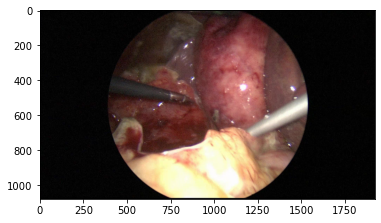

In [9]:
# Print the first sample, as an example
sample = lapchol_train.__getitem__(200)
print('Example:', sample)
pil_img = Image.open(sample['frame_path']).convert('RGB')
imshow(np.asarray(pil_img))

In [11]:
# how much frames for each label are there in lapchol_train?

total = 0
counter_dict = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
for i in range(lapchol_train.__len__()):
    sample = lapchol_train.__getitem__(i)
    label = sample.get('G_A_Grade')
    if label == 'excl':
        label = 4
    else:
        label = label
    counter_dict[int(label)] += 1
    total += 1

print(counter_dict)

for i in counter_dict:
    print(f"{i}: {counter_dict[i] / total * 100}")

total_nr_of_samples = lapchol_train.__len__()
print(f' Total number of samples: {total_nr_of_samples}')

{0: 0, 1: 161, 2: 610, 3: 0, 4: 0}
0: 0.0
1: 20.881971465629054
2: 79.11802853437095
3: 0.0
4: 0.0
 Total number of samples: 771


In [20]:
# Put Dataset in DataLoader

# adjust to ensure the data is already transformed when used as input for the Dataloader
dataloader_train = DataLoader(lapchol_train, config.batch_size, shuffle=True)
print(dataloader_train)

#sub_cholec_val = torch.utils.data.RandomSampler(cholec_val,replacement=True, num_samples=round(len(cholec_val)/5), generator=None)
dataloader_val = DataLoader(lapchol_val, config.batch_size)

print(dataloader_val)

#dataloader_test = DataLoader(cholec_test, batch_size)


# Define transforms to read images for train data
transf_train = transforms.Compose([ReadPILImage(), transforms.RandomHorizontalFlip(), transforms.Resize(256), 
transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], 
std=[0.229, 0.224, 0.225])])

def prepare_batch_train(batch, device, non_blocking):
    frame_paths = batch['frame_path']
    G_A_Grade = batch['G_A_Grade']

    imgs = []
    for frame_path in frame_paths:
        img = transf_train(frame_path)
        imgs.append(img)
    imgs = torch.stack(imgs)

    lbls = []
    for G_A_Grade in G_A_Grade:
        lbl = class_labels.index(G_A_Grade)
        lbls.append(lbl)
    lbls = torch.Tensor(lbls).type(torch.int64)

    return (imgs, lbls)

# Define transforms to read images for val data
transf_val = transforms.Compose([ReadPILImage(), transforms.Resize(256), transforms.CenterCrop(224), 
transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def prepare_batch_val(batch, device, non_blocking):
    frame_paths = batch['frame_path']
    G_A_Grade = batch['G_A_Grade']

    imgs = []
    for frame_path in frame_paths:
        img = transf_val(frame_path)
        imgs.append(img)
    imgs = torch.stack(imgs)

    lbls = []
    for G_A_Grade in G_A_Grade:
        lbl = class_labels.index(G_A_Grade)
        lbls.append(lbl)
    lbls = torch.Tensor(lbls).type(torch.int64)

    return (imgs, lbls)




In [21]:
model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features


#for binary classification:
model.fc = torch.nn.Sequential(torch.nn.Linear(num_ftrs, out_features=2,
                                               bias=True), nn.Sigmoid())

#for multiple class classification
#model.fc = torch.nn.Sequential(torch.nn.Linear(num_ftrs, out_features=3,
#                                bias=True), torch.nn.Softmax(dim=1))

#for param in model.parameters():
#    param.requires_grad = False   
#    
#model.fc = nn.Sequential(
#               nn.Linear(2048, 128),
#               nn.ReLU(inplace=True),
#               nn.Linear(128, 2)).to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
    
optimizer = Adam(model.parameters(), config.learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = torch.nn.CrossEntropyLoss()
epochs = config.epochs
    
trainer = create_supervised_trainer(model, optimizer, criterion, device=device, prepare_batch=prepare_batch_train)
    
metrics = {'accuracy':Accuracy(), 'loss':Loss(criterion), 'cm':ConfusionMatrix(num_classes=len(class_labels))}

from ignite.utils import setup_logger
trainer.logger = setup_logger("Train Logger")

val_evaluator = create_supervised_evaluator(model, metrics, device=device, prepare_batch=prepare_batch_val)
    
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

@trainer.on(Events.ITERATION_COMPLETED(every=1))
def log_training_loss(engine):
    epoch = engine.state.epoch
    max_batches = engine.state.epoch_length
    batch_nr = engine.state.iteration
    batch_nr = batch_nr - (epoch - 1) * max_batches
    loss = engine.state.output
    #wandb.log({"train loss": loss})
    
    print(f'Epoch[{epoch}] Batch[{batch_nr}/{max_batches}] Loss: {loss:.4f}')

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    val_evaluator.run(dataloader_train)
    metrics = val_evaluator.state.metrics
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(dataloader_val)
    validation_acc = val_evaluator.state.metrics["accuracy"]
    print("Epoch: {} Validation accuracy: {:.2f}".format(trainer.state.epoch, validation_acc))

    
    '''
    Using WandBLogger in ignite is a 2-step modular process: First, you need to create 
    a WandBLogger object. Then it can be attached to any trainer or evaluator to automatically log the metrics. 
    We'll do the following tasks sequentially: 1) Create a WandBLogger object
    
    Wandb Object Creation
    '''

    
    '''
 
    2) Attach the Object to the output handlers to:
    
    1) Log training loss - attach to trainer
    2) Log validation loss - attach to evaluator
    3) Log optional Parameters
    4) Watch the model
    '''
wandb_logger.attach_output_handler(
trainer,
event_name=Events.ITERATION_COMPLETED,
tag="training",
output_transform=lambda loss: {"loss": loss}
)
 
wandb_logger.attach_output_handler(
val_evaluator,
event_name=Events.EPOCH_COMPLETED,
tag="training",
metric_names=["loss", "accuracy"],
global_step_transform=lambda *_: trainer.state.iteration,
)
 
wandb_logger.attach_opt_params_handler(
trainer,
event_name=Events.ITERATION_STARTED,
optimizer=optimizer,
param_name='lr'  # optional
)
 




In [23]:
wandb_logger.watch(model,criterion,log=all,log_freq=10)

In [ ]:
trainer.run(dataloader_train, max_epochs=epochs)

2021-05-19 14:46:39,928 Train Logger INFO: Engine run starting with max_epochs=5.


Epoch[1] Batch[1/16] Loss: 0.6932
Epoch[1] Batch[2/16] Loss: 0.4847
Epoch[1] Batch[3/16] Loss: 0.4967
Epoch[1] Batch[4/16] Loss: 0.3729
Epoch[1] Batch[5/16] Loss: 0.4429
Epoch[1] Batch[6/16] Loss: 0.4333
Epoch[1] Batch[7/16] Loss: 0.3623
Epoch[1] Batch[8/16] Loss: 0.3203
Epoch[1] Batch[9/16] Loss: 0.3880
Epoch[1] Batch[10/16] Loss: 0.3873
Epoch[1] Batch[11/16] Loss: 0.4378
Epoch[1] Batch[12/16] Loss: 0.3377
Epoch[1] Batch[13/16] Loss: 0.3687
Epoch[1] Batch[14/16] Loss: 0.3558
Epoch[1] Batch[15/16] Loss: 0.3916
Epoch[1] Batch[16/16] Loss: 0.3333
Training Results - Epoch[1] Avg accuracy: 0.93 Avg loss: 0.38


2021-05-19 14:54:54,692 Train Logger INFO: Epoch[1] Complete. Time taken: 00:08:15


Epoch: 1 Validation accuracy: 0.96
